<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gradient-Descent" data-toc-modified-id="Gradient-Descent-1">Gradient Descent</a></span><ul class="toc-item"><li><span><a href="#Intuition" data-toc-modified-id="Intuition-1.1">Intuition</a></span></li><li><span><a href="#Gradient-Descent-Analysis" data-toc-modified-id="Gradient-Descent-Analysis-1.2">Gradient Descent Analysis</a></span></li><li><span><a href="#Defining-the-minimize-Function" data-toc-modified-id="Defining-the-minimize-Function-1.3">Defining the <code>minimize</code> Function</a></span></li><li><span><a href="#Minimizing-the-Huber-loss" data-toc-modified-id="Minimizing-the-Huber-loss-1.4">Minimizing the Huber loss</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.5">Summary</a></span></li></ul></li></ul></div>

In [1]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

In [2]:
# HIDDEN
tips = sns.load_dataset('tips')
tips['pcttip'] = tips['tip'] / tips['total_bill'] * 100

In [3]:
# HIDDEN
def mse(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

def grad_mse(theta, y_vals):
    return -2 * np.mean(y_vals - theta)

def plot_loss(y_vals, xlim, loss_fn):
    thetas = np.arange(xlim[0], xlim[1] + 0.01, 0.05)
    losses = [loss_fn(theta, y_vals) for theta in thetas]
    
    plt.figure(figsize=(5, 3))
    plt.plot(thetas, losses, zorder=1)
    plt.xlim(*xlim)
    plt.title(loss_fn.__name__)
    plt.xlabel(r'$ \hat{\theta} $')
    plt.ylabel('Loss')
    plt.legend()
    
def plot_theta_on_loss(y_vals, theta, loss_fn, **kwargs):
    loss = loss_fn(theta, y_vals)
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c=sns.xkcd_rgb['green'])
    plt.scatter([theta], [loss], **{**default_args, **kwargs})

def plot_tangent_on_loss(y_vals, theta, loss_fn, eps=1e-6):
    slope = ((loss_fn(theta + eps, y_vals) - loss_fn(theta - eps, y_vals))
             / (2 * eps))
    xs = np.arange(theta - 1, theta + 1, 0.05)
    ys = loss_fn(theta, y_vals) + slope * (xs - theta)
    plt.plot(xs, ys, zorder=3, c=sns.xkcd_rgb['green'], linestyle='--')

## Gradient Descent

We are interested in creating a function that can minimize a loss function without forcing the user to predetermine which values of $ \theta $ to try. In other words, while the `simple_minimize` function has the following signature:

```python
simple_minimize(lost_fn, dataset, thetas)
```

We would like a function that has the following signature:

```python
minimize(loss_fn, dataset)
```

This function needs to automatically find the minimizing $ \hat{\theta} $ value no matter how small or large it is. We will use a technique called gradient descent to implement this new `minimize` function.

### Intuition

As with loss functions, we will discuss the intuition for gradient descent first, then formalize our understanding with mathematics.

Since the `minimize` function is not given values of $ \hat{\theta} $ to try, we start by picking a $ \hat{\theta} $ anywhere we'd like. Then, we can iteratively improve the estimate of $ \hat{\theta} $. To improve an estimate of $ \hat{\theta}$, we look at the slope of the loss function at that choice of $ \hat{\theta} $.

For example, suppose we are using MSE for the simple dataset $ y = [ 12.1, 12.8, 14.9, 16.3, 17.2 ] $ and our current choice of $ \hat{\theta} $ is 12.

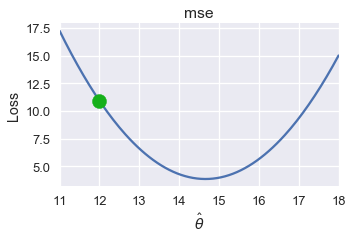

In [4]:
# HIDDEN
pts = np.array([12.1, 12.8, 14.9, 16.3, 17.2])
plot_loss(pts, (11, 18), mse)
plot_theta_on_loss(pts, 12, mse)

We'd like to choose a new value for $ \hat{\theta} $ that decreases the loss. To do this, we look at the slope of the loss function at $ \hat{\theta} = 12 $:

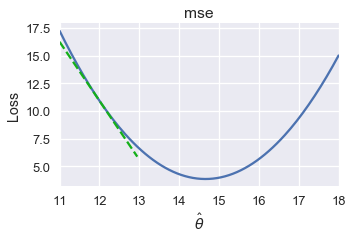

In [5]:
# HIDDEN
pts = np.array([12.1, 12.8, 14.9, 16.3, 17.2])
plot_loss(pts, (11, 18), mse)
plot_tangent_on_loss(pts, 12, mse)

The slope is negative, which means that increasing $ \hat{\theta} $ will decrease the loss.

If $ \hat{\theta} = 16.5 $ on the other hand, the slope of the loss function is positive:

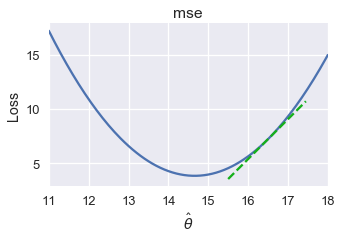

In [6]:
# HIDDEN
pts = np.array([12.1, 12.8, 14.9, 16.3, 17.2])
plot_loss(pts, (11, 18), mse)
plot_tangent_on_loss(pts, 16.5, mse)

When the slope is positive, decreasing $ \hat{\theta} $ will decrease the loss.

The slope of the tangent line tells us which direction to move $ \hat{\theta} $ in order to decrease the loss. If the slope is negative, we want $ \hat{\theta} $ to move in the positive direction. If the slope is positive, $ \hat{\theta} $ should move in the negative direction. Mathematically, we write:

$$
\hat{\theta_{t+1}} = \hat{\theta_t} - \frac{\partial}{\partial \hat{\theta}} L(\hat{\theta}, y)
$$

Where $ \hat{\theta_t} $ is the current estimate and $ \hat{\theta_{t+1}} $ is the next estimate.

For the MSE, we have:

$$
\begin{aligned}
L(\hat{\theta}, y)
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - \hat{\theta})^2\\
\frac{\partial}{\partial \hat{\theta}} L(\hat{\theta}, y)
&= \frac{1}{n} \sum_{i = 1}^{n} -2(y_i - \hat{\theta}) \\
&= -\frac{2}{n} \sum_{i = 1}^{n} (y_i - \hat{\theta}) \\
\end{aligned}
$$

When $ \hat{\theta_t} = 12 $, we can compute $ -\frac{2}{n} \sum_{i = 1}^{n} (y_i - \hat{\theta}) = -5.2 $. Thus, $ \hat{\theta_{t+1}} = 12 - (-5.2) = 17.2 $.

We've plotted the old value of $ \hat{\theta} $ as a green outlined circle and the new value as a filled in circle on the loss curve below.

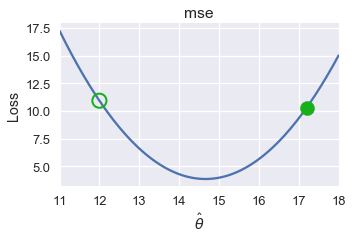

In [7]:
# HIDDEN
pts = np.array([12.1, 12.8, 14.9, 16.3, 17.2])
plot_loss(pts, (11, 18), mse)
plot_theta_on_loss(pts, 12, mse, c='none',
                   edgecolor=sns.xkcd_rgb['green'], linewidth=2)
plot_theta_on_loss(pts, 17.2, mse)

Although $ \hat{\theta} $ went in the right direction, it ended up as far away from the minimum as it started. We can remedy this by multiplying the slope by a small constant before subtracting it from $ \hat{\theta}$. Our final update formula is:

$$
\hat{\theta_{t+1}} = \hat{\theta_t} - \alpha \cdot \frac{\partial}{\partial \hat{\theta}} L(\hat{\theta}, y)
$$

Where $ \alpha $ is a small constant. For example, if we set $ \alpha = 0.3 $ this is the new $ \hat{\theta_{t+1}} $:

In [8]:
# HIDDEN
def plot_one_gd_iter(y_vals, theta, loss_fn, grad_loss, alpha=0.3):
    new_theta = theta - alpha * grad_loss(theta, y_vals)
    plot_loss(pts, (11, 18), loss_fn)
    plot_theta_on_loss(pts, theta, loss_fn, c='none',
                       edgecolor=sns.xkcd_rgb['green'], linewidth=2)
    plot_theta_on_loss(pts, new_theta, loss_fn)
    print(f'old theta_hat: {theta}')
    print(f'new theta_hat: {new_theta}')

old theta_hat: 12
new theta_hat: 13.596


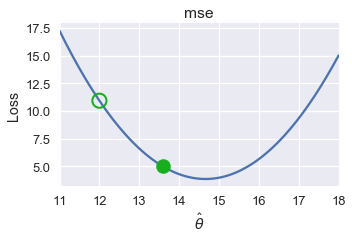

In [9]:
# HIDDEN
plot_one_gd_iter(pts, 12, mse, grad_mse)

Here are the $ \hat{\theta} $ values for successive iterations of this process. Notice that $ \hat{\theta} $ changes more slowly as it gets closer to the minimum loss because the slope is also smaller.

old theta_hat: 13.6
new theta_hat: 14.236


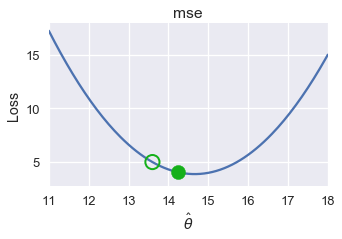

In [10]:
# HIDDEN
plot_one_gd_iter(pts, 13.60, mse, grad_mse)

old theta_hat: 14.24
new theta_hat: 14.492


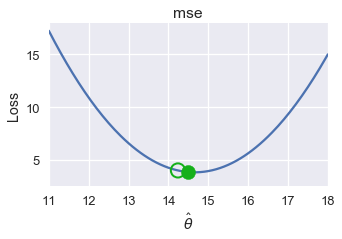

In [11]:
# HIDDEN
plot_one_gd_iter(pts, 14.24, mse, grad_mse)

old theta_hat: 14.49
new theta_hat: 14.592


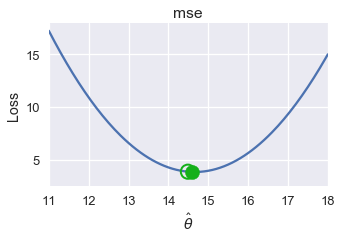

In [12]:
# HIDDEN
plot_one_gd_iter(pts, 14.49, mse, grad_mse)

### Gradient Descent Analysis

We now have the full algorithm for gradient descent:

1. Choose a starting value of $ \hat{\theta} $ (0 is a common choice).
2. Compute $ \hat{\theta} - \alpha \cdot \frac{\partial}{\partial \theta} L(\hat{\theta}, y) $ and store this as the new value of $ \theta $.
3. Repeat until $ \hat{\theta} $ doesn't change between iterations.

You will more commonly see the gradient $ \nabla_\theta $ in place of the partial derivative $ \frac{\partial}{\partial \theta} $. The two notations are essentially equivalent, but since the gradient notation is more common we will use it in the gradient update formula from now on:

$$
\hat{\theta_{t+1}} = \hat{\theta_t} - \alpha \cdot \nabla_\theta L(\hat{\theta}, y)
$$

To review notation:

- $ \hat{\theta_t} $ is the current choice of $ \hat{\theta} $.
- $ \hat{\theta_{t+1}} $ is the next choice of $ \hat{\theta} $.
- $ \alpha $ is called the learning rate, usually set to a small constant. Sometimes it is useful to start with a larger $ \alpha $ and decrease it over time. If $ \alpha $ changes between iterations, we use the variable $ \alpha_t $ to mark that $ \alpha $ varies over time $ t $.
- $ \nabla_\theta L(\hat{\theta}, y) $ is the partial derivative / gradient of the loss function at $ \hat{\theta} $.

You can now see the importance of choosing a differentiable loss function: $ \nabla_\theta L(\hat{\theta}, y) $ is a crucial part of the gradient descent algorithm. (While it is possible to estimate the gradient by computing the difference in loss for two slightly different values of $ \hat{\theta} $ and dividing by the distance between $ \hat{\theta} $ values, this typically increases the runtime of gradient descent so significantly that it becomes impractical to use.)

The gradient algorithm is simple yet powerful since we can use it for many types of models and many types of loss functions. It is the computational tool of choice for fitting many important models, including linear regression on large datasets and neural networks.

### Defining the `minimize` Function

Now we return to our original task: defining the `minimize` function. We will have to change our function signature slightly since we now need to compute the gradient of the loss function. 

In [13]:
def minimize(loss_fn, grad_loss_fn, dataset, alpha=0.2, progress=True):
    '''
    Uses gradient descent to minimize loss_fn. Returns the minimizing value of
    theta_hat once theta_hat changes less than 0.001 between iterations.
    '''
    theta_hat = 0
    while True:
        if progress:
            print(f'theta: {theta_hat:.2f} | loss: {loss_fn(theta_hat, dataset):.2f}')
        gradient = grad_loss_fn(theta_hat, dataset)
        new_theta_hat = theta_hat - alpha * gradient
        
        if abs(new_theta_hat - theta_hat) < 0.001:
            return new_theta_hat
        
        theta_hat = new_theta_hat

Then we can define functions to compute our MSE and its gradient:

In [14]:
def mse(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

def grad_mse(theta, y_vals):
    return -2 * np.mean(y_vals - theta)

Finally, we can use the `minimize` function to compute the minimizing value of $ \hat{\theta} $ for $ y = [12.1, 12.8, 14.9, 16.3, 17.2] $.

In [15]:
%%time
theta_hat = minimize(mse, grad_mse, np.array([12.1, 12.8, 14.9, 16.3, 17.2]))
print(f'Minimizing theta_hat: {theta_hat}')
print()

theta: 0.00 | loss: 218.76
theta: 5.86 | loss: 81.21
theta: 9.38 | loss: 31.70
theta: 11.49 | loss: 13.87
theta: 12.76 | loss: 7.45
theta: 13.52 | loss: 5.14
theta: 13.98 | loss: 4.31
theta: 14.25 | loss: 4.01
theta: 14.41 | loss: 3.90
theta: 14.51 | loss: 3.86
theta: 14.57 | loss: 3.85
theta: 14.61 | loss: 3.85
theta: 14.63 | loss: 3.84
theta: 14.64 | loss: 3.84
theta: 14.65 | loss: 3.84
theta: 14.65 | loss: 3.84
theta: 14.66 | loss: 3.84
theta: 14.66 | loss: 3.84
Minimizing theta_hat: 14.658511131035242

Wall time: 997 µs


We can see that gradient quickly finds the same solution as the analytic method:

In [16]:
np.mean([12.1, 12.8, 14.9, 16.3, 17.2])

14.66

### Minimizing the Huber loss

Now, we can apply gradient descent to minimize the Huber loss on our dataset of tip percentages.

The Huber loss is:

$$
L_\delta(\hat{\theta}, y) = \frac{1}{n} \sum_{i=1}^n \begin{cases}
    \frac{1}{2}(y_i - \hat{\theta})^2 &  | y_i - \hat{\theta} | \le \delta \\
     \delta (|y_i - \hat{\theta}| - \frac{1}{2} \delta ) & \text{otherwise}
\end{cases}
$$

The gradient of the Huber loss is:

$$
\nabla_{\hat{\theta}} L_\delta(\hat{\theta}, y) = \frac{1}{n} \sum_{i=1}^n \begin{cases}
    -(y_i - \hat{\theta}) &  | y_i - \hat{\theta} | \le \delta \\
    - \delta \cdot \text{sign} (y_i - \hat{\theta}) & \text{otherwise}
\end{cases}
$$

(Note that in previous definitions of Huber loss we used the variable $ \alpha $ to denote the transition point. To avoid confusion with the $ \alpha $ used in gradient descent, we replace the transition point parameter of the Huber loss with $ \delta $.)

In [17]:
def huber_loss(theta, dataset, delta = 1):
    d = np.abs(theta - dataset)
    return np.mean(
        np.where(d <= delta,
                 (theta - dataset)**2 / 2.0,
                 delta * (d - delta / 2.0))
    )

def grad_huber_loss(theta, dataset, delta = 1):
    d = np.abs(theta - dataset)
    return np.mean(
        np.where(d <= delta,
                 -(dataset - theta),
                 -delta * np.sign(dataset - theta))
    )

Let's minimize the Huber loss on the tips dataset:

In [18]:
%%time
theta_hat = minimize(huber_loss, grad_huber_loss, tips['pcttip'], progress=False)
print(f'Minimizing theta_hat: {theta_hat}')
print()

Minimizing theta_hat: 15.506849531471964

Wall time: 170 ms


### Summary

Gradient descent gives us a generic way to minimize a loss function when we cannot solve for the minimizing value of $ \hat{\theta} $ analytically. As our models and loss functions increase in complexity, we will turn to gradient descent as our tool of choice to fit models.